In [6]:
FILE_PATH = '../data/ehresp_2014.xlsx'

# Import libraries
import pandas as pd

# Load the ehresp_2014 DataFrame
ehresp_2014 = pd.read_excel(FILE_PATH)

from enum import Enum
class FEATURE_SELECTION_OPTIONS(Enum):
    K_BEST = 'k_best',
    NONE = 'none'

def do_the_stuff(feature_selection_option):
    from enum import Enum
    class COLUMN_TYPES(Enum):
        NUMERICAL = 'numerical',
        CATEGORICAL = 'categorical'

    numerical_columns = ['ertpreat', \
                         'ertseat', \
                         'euexfreq', \
                         'eufastfdfrq']

    categorical_columns = ['eeincome1', \
                           'erhhch', \
                           'erincome', \
                           'erspemch', \
                           'eudietsoda', \
                           'eudrink', \
                           'eueat', \
                           'euexercise', \
                           'eufastfd', \
                           'euffyday', \
                           'eufdsit', \
                           'eusnap', \
                           'eugenhth', \
                           'eugroshp', \
                           'euinclvl', \
                           'euincome2', \
                           'eumeat', \
                           'eumilk', \
                           'euprpmel', \
                           'eusoda', \
                           'eustores', \
                           'eustreason', \
                           'eutherm', \
                           'euwic']

    target_column = 'erbmi'
    
    def drop_records_with_negagive_values_in_column(dataset, col):
        return dataset.loc[dataset[col] >= 0]

    def split_data(dataset):
        import numpy as np
        length = dataset.shape[0]
        train_index_stop = int(length * 0.7)
        permutation = np.random.RandomState(0).permutation(length)

        # Take just the values up to the train_index_stop
        train_permutation = permutation[:train_index_stop]
        # Take the values after the train_index_stop
        test_permutation = permutation[train_index_stop:]

        # Create the training and testing data
        dataset_train = dataset[train_permutation]
        dataset_test = dataset[test_permutation]

        return [dataset_train, dataset_test]

    def prepare_categorical_columns(dataset, columns):
        import pandas as pd
        from sklearn.preprocessing import LabelEncoder

        # Extract columns from dataset; convert to array
        dataset = dataset[columns].values

        # Apply LabelEncoder to multiple columns: https://stackoverflow.com/a/31939145
        dataset = pd.DataFrame(dataset).apply(LabelEncoder().fit_transform).values

        # OHE for multiple columns using pd.get_dummies: https://stackoverflow.com/a/44601764
        # Another get_dummies example: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
        # OHE vs. get_dummies: https://medium.com/@guaisang/handling-categorical-features-get-dummies-onehotencoder-and-multicollinearity-f9d473a40417
        dataset_df = pd.DataFrame(dataset, columns=columns)
        # Keep only the columns we want, and drop the extraneous dummy column
        dataset_dummies = pd.get_dummies(dataset_df,
                                         columns=columns,
                                         drop_first=True)
        dataset = dataset_dummies.values

        # Split dataset
        dataset_train, dataset_test = split_data(dataset)

        return [dataset_train, dataset_test]

    def prepare_numerical_columns(dataset, columns):
        # Extract columns from dataset; convert to array
        dataset = dataset[columns].values

        # Split dataset
        X_train, X_test = split_data(dataset)

        # Scale values
        from sklearn.preprocessing import StandardScaler
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)

        return [X_train, X_test]

    # Define a function to return BMI class
    def get_bmi_class(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif bmi >= 18.5 and  bmi < 25:
            return 'Normal'
        elif bmi >= 25 and bmi < 30:
            return 'Overweight'
        elif bmi >= 30:
            return 'Obese'
        else:
            return 'Unknown'

    def prepare_target_column(dataset, column, return_column_type):
        import numpy as np
        import pandas as pd
        dataset = dataset[column].values

        if (return_column_type == COLUMN_TYPES.CATEGORICAL):
            dataset = np.asarray(pd.Series(get_bmi_class(bmi) for bmi in dataset))

        # Split dataset
        dataset_train, dataset_test = split_data(dataset)

        return [dataset_train, dataset_test]


    def prepare_data(dataset,
                     categorical_columns,
                     numerical_columns,
                     target_column,
                     target_column_return_type):
        print('\nBegin prepare_data')
        import pandas as pd
        
        dataset = drop_records_with_negagive_values_in_column(dataset, target_column)
        
        X_categorical_train, \
        X_categorical_test = prepare_categorical_columns(dataset, categorical_columns)

        X_numerical_train, \
        X_numerical_test = \
        prepare_numerical_columns(dataset, numerical_columns)

        X_train = pd.DataFrame(X_numerical_train) \
        .merge(pd.DataFrame(X_categorical_train),
               how='outer',
               left_index=True,
               right_index=True) \
        .values
        print('X_train shape:', X_train.shape)

        X_test = pd.DataFrame(X_numerical_test) \
        .merge(pd.DataFrame(X_categorical_test),
               how='outer',
               left_index=True,
               right_index=True) \
        .values
        print('X_test shape:', X_test.shape)

        y_train, \
        y_test = \
        prepare_target_column(dataset, target_column, target_column_return_type)

        print('y_train shape:', y_train.shape)
        print('y_test shape:', y_test.shape)

        print('End prepare_data()\n')
        return [X_train, X_test, y_train, y_test]

    X_train, X_test, \
    y_train, y_test = \
    prepare_data(dataset = ehresp_2014,
                 categorical_columns = categorical_columns,
                 numerical_columns = numerical_columns,
                 target_column = target_column,
                 target_column_return_type = COLUMN_TYPES.CATEGORICAL)

    if(feature_selection_option == FEATURE_SELECTION_OPTIONS.K_BEST):
        def select_k_best_categorical_features(X_train,
                                               y_train,
                                               X_test,
                                               first_categorical_column_index,
                                               k_best,
                                               score_function):
            print('\nBegin select_k_best_categorical_features()')
            from sklearn.feature_selection import SelectKBest
            import numpy as np

            print('Before selection: X_train.shape', X_train.shape)

            select_k_best = SelectKBest(score_func = score_function, k = k_best)
            fit = select_k_best.fit(X_train[:, first_categorical_column_index:], y_train)

            def transform(arr, fit, first_categorical_column_index):
                arr_numerical = arr[:, :first_categorical_column_index]
                arr_categorical = arr[:, first_categorical_column_index:]
                features = fit.transform(arr_categorical)
                return np.append(arr_numerical, features, axis=1)

            X_train = transform(arr = X_train,
                                fit = fit,
                                first_categorical_column_index = first_categorical_column_index)

            print('After selection: X_train.shape', X_train.shape)
            print('After selection: X_train:\n', X_train)

            print('Before selection: X_test.shape', X_test.shape)
            X_test = transform(arr = X_test,
                               fit = fit,
                               first_categorical_column_index = first_categorical_column_index)
            print('After selection: X_test.shape', X_test.shape)
            print('After selection: X_test:\n', X_test)

            print('End select_k_best_categorical_features()\n')
            return [X_train, X_test]


        # https://www.datacamp.com/community/tutorials/feature-selection-python
        # Note that `chi2` works _only_ for non-negative categorical data
        from sklearn.feature_selection import chi2

        X_train, X_test = select_k_best_categorical_features(X_train = X_train,
                                                             y_train = y_train,
                                                             X_test = X_test,
                                                             first_categorical_column_index = 4, 
                                                             k_best = 25,
                                                             score_function = chi2)
        
    
    return [X_train, X_test, y_train, y_test]

X_train, X_test, \
y_train, y_test = do_the_stuff(feature_selection_option = FEATURE_SELECTION_OPTIONS.NONE)


Begin prepare_data
X_train shape: (7445, 92)
X_test shape: (3192, 92)
y_train shape: (7445,)
y_test shape: (3192,)
End prepare_data()



/Users/ehelander/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
def get_optimum_features(X_train,
                         y_train,
                         estimator,
                         cv,
                         scoring):
    # https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
    from sklearn.feature_selection import RFECV

    rfecv = RFECV(estimator,
                  step = 1,
                  cv = cv,
                  scoring = scoring
                 )

    rfecv.fit(X_train, y_train)
    
    # Plot number of features VS. cross-validation scores
    import matplotlib.pyplot as plt
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    import numpy as np
    print('The highest accuracy, %2.4f, is achieved with %2d features.' % (np.amax(rfecv.grid_scores_), np.argmax(rfecv.grid_scores_)))
    
    print('Ranking of features (`1` indicates selected):\n', rfecv.ranking_)
    
    return rfecv


Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


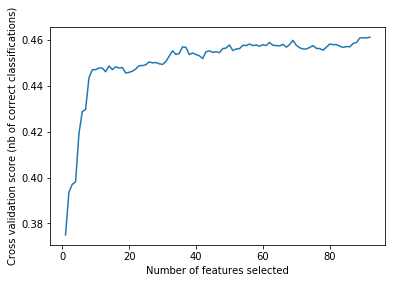

The highest accuracy, 0.4611, is achieved with 91 features.
Ranking of features (`1` indicates selected):
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


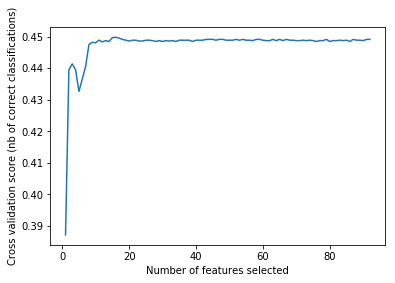

The highest accuracy, 0.4498, is achieved with 15 features.
Ranking of features (`1` indicates selected):
 [ 1 16  1  1 11  1  9  8  7 13  6 21 22 25 28 34 29 37  2  1 43 45  1  1
 32 36 40 42 48 51  1 53 55  1 60 62 64 66 68 70 72 74 76 77  1  1  1 15
 19 20  4 23 24  1 35 17 18 41  5 12 26  1 38 27 30 31 33 39  1 44 47 49
 50 52 54 56 58 57 46 14 59 61 63 65 67 69 71 73 75  1 10  3]

Estimator:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [ ]:
# Logistic Regression (from bmiClassify)
from sklearn.linear_model import LogisticRegression
logisticRegression = LogisticRegression(random_state=0)

# Decision Tree Classifier (from DTCategorical)
from sklearn.tree import DecisionTreeClassifier
decisionTree = DecisionTreeClassifier(max_depth = 5)

# Support Vector Machine
from sklearn.svm import SVC
svc = SVC(kernel='linear')

estimators = [logisticRegression, decisionTree, svc]
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(5)
scoring = 'accuracy'

for estimator in estimators:
    print('\nEstimator: ', estimator)
    output = get_optimum_features(X_train,
                                  y_train,
                                  estimator, 
                                  cv,
                                  scoring)